# Warp Simulation

## Pseudorandom number generator (PRNG)
PRNG is an algorithm to generate a sequence of numbers whose properties approximate the properties of sequences of random numbers. In fact, the sequence is not truly rando, and it is completely determined by an initial value. 

In [29]:
# package importing
import random
from matplotlib import pyplot as plt
import time
import statistics
import numpy as np
import sys

# for speed up
from numba import jit

# settings
np.set_printoptions(threshold=sys.maxsize)

In [30]:
# operating system settings
import os
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda-10.1/nvvm/libdevice'
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda-10.1/nvvm/lib64/libnvvm.so'

In [38]:
import collections

""""
Implements the Subtractive PRNG used by C#: https://rosettacode.org/wiki/Subtractive_generator#C.2B.2B.
seed is used to define a new generation for the PRNG. A new call of the srand function is always either a new generation based on that seed alone.

:param seed: the seed used for generation. It has to be a value within 1-10^9. Keep in mind this parameter is not persisted between calls. One function call has its own instance. 
"""
def srand(seed):
    r = collections.deque(maxlen=55)
    s = collections.deque(maxlen=55)
    m = 10**9
    s.extend([seed, 1])
    s.extend((s[n-2] - s[n-1]) % m for n in range(2, 55))
    r.extend(s[(34 * (n+1)) % 55] for n in range(55))
    for _ in range(219-54):
        r.append((r[0] - r[31]) % m)
    while True:
        r.append((r[0] - r[31]) % m)
        yield r[54]

# Verify our SPRNG works
x = srand(1029202)
print(next(x))

521657541


In [32]:
"""
Calculates the probability between N times of iterations.
:param seed: the seed used by the PRNG to calculate the rate of roll. This could be any positive integers from 1 to 10^9.
:param rate: the rate of the roll. By default it uses 0.02.
:param iterations: the N amount of iterations to perform to check for a probability
:param total_samples: the amount of total samples to check against.
"""
# We're using Numba to speed up our increments, since the LLVM opcodes is going to help us alot.
@jit(parallel=True, forceobj=True)
def get_probability(seed, rate, rate_increment, iterations, total_samples, debug=False):

    tl_mean_list = []

    prng = srand(seed)
    s = 0
    start = time.time()

    while s < iterations:
        trial_list = []
        a = 0

        while a < total_samples:
            trial = 1
            x = next(prng) / 10**9
            rate_current = rate
            while x > rate_current:
                trial += 1
                x = next(prng) / 10**9
                if trial > 50:
                    rate_current += rate_increment
                
            a += 1
            trial_list.append(trial)
        
        eee = sum(trial_list) / iterations
        tl_mean_list.append(eee)
        s += 1

        if s % 100 == 0 and debug is True:
            endf = time.time()
            print('progress =','%.2f' % (s*100/iterations),'% (time =','%.2f' % (endf-start),'s)')
  
    return tl_mean_list

mean = 34.512800999999975
variance = 0.45533237577477464
sd = 0.6747832065002616
[33.879, 35.863, 34.849, 33.938, 34.554, 33.218, 33.842, 35.805, 33.283, 34.776, 34.117, 35.658, 35.205, 34.833, 35.082, 34.177, 33.998, 34.016, 34.647, 35.536, 34.753, 34.902, 34.593, 34.625, 34.114, 35.035, 34.108, 35.364, 33.95, 35.957, 34.975, 34.421, 34.749, 34.302, 34.077, 35.049, 34.373, 33.882, 35.882, 34.999, 33.89, 34.813, 36.01, 35.178, 34.354, 33.225, 34.441, 34.493, 33.975, 33.271, 34.846, 34.696, 36.106, 35.175, 33.729, 34.596, 33.679, 34.348, 33.859, 34.088, 33.097, 34.36, 34.428, 34.716, 33.779, 35.93, 34.121, 34.667, 34.15, 35.432, 33.712, 34.624, 34.924, 34.994, 34.486, 34.515, 34.523, 33.951, 35.388, 34.937, 33.896, 34.288, 33.346, 34.73, 33.947, 34.885, 34.638, 35.431, 34.938, 33.755, 34.06, 34.441, 34.294, 33.639, 33.803, 35.232, 35.035, 34.822, 33.283, 35.15, 34.179, 34.226, 34.827, 34.323, 34.242, 34.502, 34.611, 34.107, 34.312, 34.09, 34.998, 34.126, 34.479, 34.785, 34.079, 35.079, 

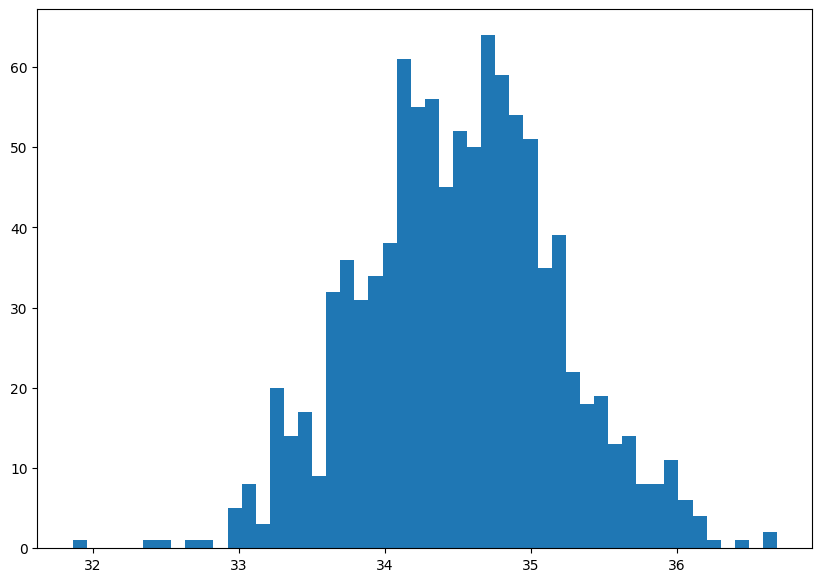

In [33]:
# Number of iterations
N = 1000
# Sample Size
sN = 1000

# Execute. Keep in mind it may take a while for the function to complete since it's going through a large number of iterations.
tl_mean_list = get_probability(102927162, 0.02, 0.02, N, sN)

var = statistics.variance(tl_mean_list)

print('mean =',sum(tl_mean_list)/sN)
print('variance =',var)
print('sd =',np.sqrt(var))
print(tl_mean_list)

fig, ax = plt.subplots(figsize = (10,7))
ax.hist(tl_mean_list, bins = 50)

plt.show()

In [34]:
print(min(tl_mean_list))
print(max(tl_mean_list))

31.862
36.686


mean = 34.43346938775508
variance = 1.9873416565656568
sd = 1.4097310582397116


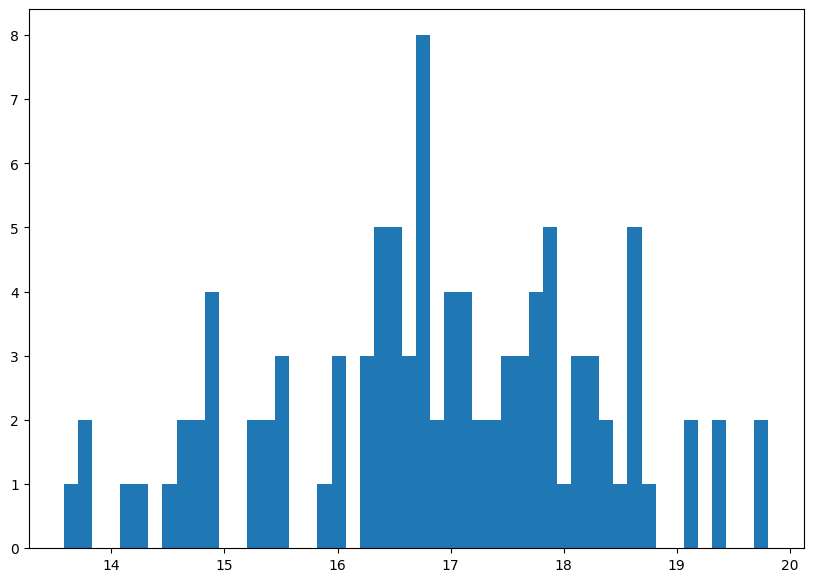

In [35]:

# Number of iterations
N = 100
# Sample Size
sN = 49

# Execute. Keep in mind it may take a while for the function to complete since it's going through a large number of iterations.
tl_mean_list = get_probability(int(time.time()), 0.02, 0.02, N, sN)

var = statistics.variance(tl_mean_list)

print('mean =',sum(tl_mean_list)/sN)
print('variance =',var)
print('sd =',np.sqrt(var))

fig, ax = plt.subplots(figsize = (10,7))
ax.hist(tl_mean_list, bins = 50)

plt.show()

In [36]:
import collections

_ten2nine = 10**9

class Subtractive_generator():
    
    def __init__(self, seed=292929):
        self.r = collections.deque(maxlen=55)
        s = collections.deque(maxlen=55)
        s.extend([seed, 1])
        s.extend((s[n-2] - s[n-1]) % _ten2nine for n in range(2, 55))
        self.r.extend(s[(34 * (n+1)) % 55] for n in range(55)) 
        for n in range(219 - 54):
            self()
     
    def __call__(self):
        r = self.r
        r.append((r[0] - r[31]) % _ten2nine)
        return r[54]
     
if __name__ == '__main__':
    srand = Subtractive_generator()
    print([srand() for i in range(5)])

[467478574, 512932792, 539453717, 20349702, 615542081]
